# TL;DR (Final model):

This is our final model. Classification is based on Random Forest.
   - We tried some different classifiers (MLP, LR, XGBOOST) and we found that the RF gave us the best $F_1$ score.
   - Random forest is a simple model, yet powerful and easy to train, and can handle with imbalanced data.
   - We handle with the imbalance by some resampling methods (and choose the best).
   - We fine-tune our hyper-parameters with Randomized search.
   - We didn't use all the features (only part of the vital signs and laboratory values. For more details, plese check our first analysis.
   - We measured 3 diffrenet metrics: $F_1$ (requested), $Recall$, as explained before (base model section), this is a significant score when dealing with critical classification of medical data. $ Balanced Accuracy$ -  kind of accuracy, but computed for imbalanced data (like ours). We know that regular accuracy is useless here and non-informative, so this one more robust to the imbalance (but still not standalone).
   - We split our training set to train:validation with ratio of 80:20.
   - We transform our data in a a special way: for every patient, we took only the main stats (like mean, std, median, max, min 0.25 qunatile and 0.75 quantile) of each column (18 columns) and now we have 18*7=126 features for every patient. Final result contains 1 row of these stats for every patient (instead of full dataframe). This made the data more simple to use, gave us the oppurunity to resample the data with <code>imbalanced-learn</code> package and finally gave us better result than using the data as is.

# Preprocessing:

In [1]:
import pandas as pd
import numpy as np
import joblib
from Analysis.utils import concat_data
from RF_Classifier.utils import transform_stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

The columns we chose to work with, based on our first analysis and some trials. We work with all the vital signs and with the lab-test result:

In [2]:
columns = ["HR", "O2Sat", "Temp", "MAP", "Resp", "AST", "BUN",
           "Alkalinephos", "Calcium", "Creatinine", "Glucose", "Bilirubin_total",
           "Hgb", "PTT", "WBC", "Fibrinogen", "Platelets", "ICULOS"]

Load data and impute missing data (read full docs of 'concat_data' in our <code>RF_Classifier.utils</code> file, simply fill backward&forward / interpolation of nearest values according to the state of the column):

In [3]:
df = concat_data(src_dir='Data/sliced/train', dst_dir='RF_Data', name='train', impute='rf')

100%|████████████████████████████████████████████████████████████████| 20000/20000 [09:09<00:00, 36.39it/s]


Transform data to stats only, each patient has now mean, median, std, etc. summerize all his hours in ICU
(read docs of 'transform_stats' in our <code>RF_Classifier.utils</code> file).

In [5]:
tdf = transform_stats(df, columns)
transformed_df = tdf.copy()

100%|████████████████████████████████████████████████████████████████| 20000/20000 [15:06<00:00, 22.06it/s]


In [47]:
transformed_df.head(2)

,HR_count,HR_mean,HR_std,HR_min,HR_25%,HR_50%,HR_75%,HR_max,O2Sat_count,O2Sat_mean,...,ICULOS_count,ICULOS_mean,ICULOS_std,ICULOS_min,ICULOS_25%,ICULOS_50%,ICULOS_75%,ICULOS_max,PatientID,SepsisLabel
0,23.0,60.956522,7.957148,54.0,57.0,60.0,62.5,94.0,23.0,97.086957,...,23.0,12.0,6.782330,1.0,6.5,12.0,17.5,23.0,0,0
1,25.0,87.760000,6.808573,79.0,82.0,85.0,93.0,101.0,25.0,100.000000,...,25.0,14.0,7.359801,2.0,8.0,14.0,20.0,26.0,1,1


Load labels and sort corresponding to the samples (<code>train_labels.csv</code> from our analysis):

In [7]:
# train_labels.loc[id: int] returns the label of patient_id.psv
train_labels = pd.read_csv('Data/sliced/train_labels.csv', index_col=0)

In [8]:
# Add labels
transformed_df['SepsisLabel'] = transformed_df['PatientID'].apply(lambda k: int(train_labels.loc[k]))

In [9]:
transformed_df.to_csv('RF_Data/train_ready_to_go.csv')

In [10]:
X = np.array(transformed_df.drop(columns=['PatientID', 'SepsisLabel']))
y = np.array(transformed_df['SepsisLabel'])

In [62]:
# Split:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True)
print("Training size: {},\tValidation size: {}.".format(X_train.shape[0], X_val.shape[0]))

Training size: 16000,	Validation size: 4000.


# Resampling:

We will try some methods both over-sampling and combination of under-over sampling. Some techniques used below are heuristic. We found this library <code>imbalanced-learn</code> (MIT-licensed) very useful, designed to fit sklearn and has great documentation with plots and math formulation. Of course, we'll choose the method that will give the highest score on the validation set after training.

In [12]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN

In [63]:
X1, y1 = SMOTE(random_state=42).fit_resample(X_train, y_train)
X2, y2 = ADASYN(random_state=42).fit_resample(X_train, y_train)
ros = RandomOverSampler(random_state=42) # randomly over-sampling with replacement:
X3, y3 = ros.fit_resample(X_train, y_train)
smote_tomek = SMOTETomek(random_state=42) # Combined method: synthetic minority over-sampling technique:
X4, y4 = smote_tomek.fit_resample(X_train, y_train)
smote_enn = SMOTEENN(random_state=42) # Combined method: adaptive synthetic sampling:
X5, y5 = smote_enn.fit_resample(X_train, y_train)

# Training:

3 important metrics:
    - $F_1$: the main metric of the assignment.
    - $Recall$: as explained before (base model section), this is a significant score when dealing with critical classification of medical data.
    - $Accuracy_{balanced}$: kind of accuracy, but computed for imbalanced data (like ours). We know that regular accuracy is useless here and non-informative, so this one more robust to the imbalance (but still not standalone).

### Random forest:

In [17]:
from sklearn.metrics import f1_score, balanced_accuracy_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

First, we will tune our random forest (find best hyper-params) with our original train set, witout resampling. Then, we will take these hyper-params and try all the resampling techniques above. Find best hyper parameters:

In [18]:
n_estimators = [int(x) for x in np.linspace(start=100, stop=700, num=5)] # Number of trees in random forest
max_depth = [int(x) for x in np.linspace(start=10, stop=55, num=5)] # Max number of levels in tree
max_depth.append(None)
min_samples_split = [2, 3, 4, 5] # Min numbers of samples required to split a node
min_samples_leaf = [1, 4, 8] # Min numbers of sample required at each leaf node

In [19]:
random_grid = {'n_estimators': n_estimators, 'max_depth': max_depth, 
               'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}

In [20]:
RFC = RandomForestClassifier()
RFC_grid = RandomizedSearchCV(estimator=RFC, param_distributions=random_grid,
                              n_iter=10, random_state=42, n_jobs=-1, scoring='f1', error_score='raise')

In [ ]:
RFC_grid.fit(X_train, y_train)

In [23]:
# Base model:
base_model = RandomForestClassifier()
base_model.fit(X_train, y_train)
f1_base = f1_score(y_val, base_model.predict(X_val))
# Best random
best_random = RFC_grid.best_estimator_
f1_best = f1_score(y_val, best_random.predict(X_val))
print("F1 base:\t{}\t\tF1 best:\t{}".format(f1_base, f1_best))

F1 base:	0.6804597701149425		F1 best:	0.6758620689655173


Now, lets use these hyper-parameters to find the best resampling method:

In [64]:
RFC0 = RandomForestClassifier(n_estimators=400 ,n_jobs=-1)
RFC1 = RandomForestClassifier(n_estimators=400 ,n_jobs=-1)
RFC2 = RandomForestClassifier(n_estimators=400 ,n_jobs=-1)
RFC3 = RandomForestClassifier(n_estimators=400 ,n_jobs=-1)
RFC4 = RandomForestClassifier(n_estimators=400 ,n_jobs=-1)
RFC5 = RandomForestClassifier(n_estimators=400 ,n_jobs=-1)

In [65]:
RFC = [RFC0, RFC1, RFC2, RFC3, RFC4, RFC5]
data = [(X_train, y_train), (X1, y1), (X2, y2), (X3, y3), (X4, y4), (X5, y5)]
text = ['Without','SMOTE', 'ADASYN', 'Random', 'SMOTETomek', 'SMOTEENN']

Train:

In [66]:
scores = {'$F1$': [], 'Recall': [], 'Balanced Accuracy': []}
for i in range(len(RFC)):
    X_train = data[i][0]
    labels = data[i][1]
    RFC[i].fit(X_train, labels)
    train_pred = RFC[i].predict(X_train)
    val_pred = RFC[i].predict(X_val)
    print('----- '+text[i]+' resampling: -----')
    score1 = f1_score(y_val, val_pred)
    print('\tTrain F1 score:', f1_score(labels, train_pred), ' \t\tValidation F1 score:', score1)
    scores['$F1$'].append(score1)
    score2 = balanced_accuracy_score(y_val, val_pred)
    print('\tTrain balanced-accuracy:', balanced_accuracy_score(labels, train_pred), ' \tValidation balanced-accuracy:', score2)
    scores['Balanced Accuracy'].append(score2)
    score3 = recall_score(y_val, val_pred)
    print('\tTrain Recall:', recall_score(labels, train_pred), ' \t\tValidation Recall:', score3)
    scores['Recall'].append(score3)

----- Without resampling: -----
	Train F1 score: 1.0  		Validation F1 score: 0.7068965517241379
	Train balanced-accuracy: 1.0  	Validation balanced-accuracy: 0.7874658597542947
	Train Recall: 1.0  		Validation Recall: 0.5795053003533569
----- SMOTE resampling: -----
	Train F1 score: 1.0  		Validation F1 score: 0.6856060606060606
	Train balanced-accuracy: 1.0  	Validation balanced-accuracy: 0.8111788925108683
	Train Recall: 1.0  		Validation Recall: 0.6395759717314488
----- ADASYN resampling: -----
	Train F1 score: 1.0  		Validation F1 score: 0.676416819012797
	Train balanced-accuracy: 1.0  	Validation balanced-accuracy: 0.8162282740650112
	Train Recall: 1.0  		Validation Recall: 0.6537102473498233
----- Random resampling: -----
	Train F1 score: 1.0  		Validation F1 score: 0.7142857142857143
	Train balanced-accuracy: 1.0  	Validation balanced-accuracy: 0.797259463966058
	Train Recall: 1.0  		Validation Recall: 0.6007067137809188
----- SMOTETomek resampling: -----
	Train F1 score: 1.0  	

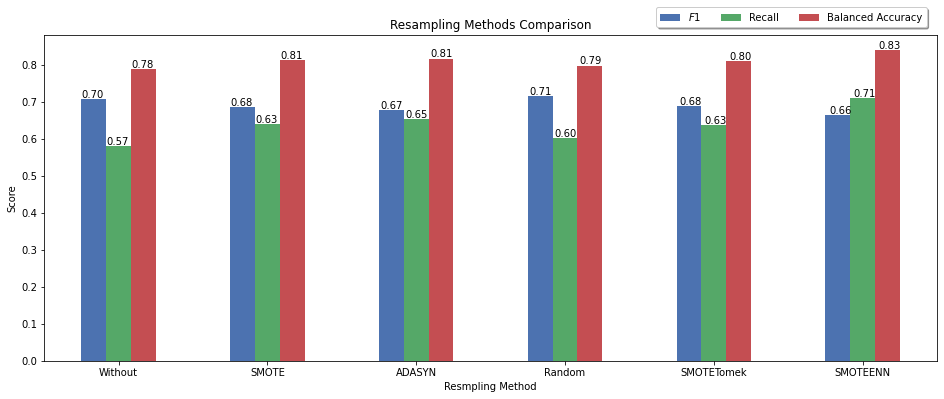

In [67]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
df = pd.DataFrame(scores, index=text)
ax = df.plot(kind='bar', stacked=False, figsize=(16, 6), rot=0, xlabel='Resmpling Method', ylabel='Score',
             title='Resampling Methods Comparison')
for p in ax.patches:
    ax.annotate(str(p.get_height())[:4], (p.get_x() * 1.005, p.get_height() * 1.005))
ax.legend(loc='upper left', bbox_to_anchor=(0.68, 1.1),
          ncol=3, fancybox=True, shadow=True)
plt.show()

We can clearly observe that the first model (without resampling) gave us $F_1=0.7068$ which is a bit higher compare to the other methods. The model that achieved the highest score is trained with random sampling and achieved $F_1=0.7142$ It's interesting that the random is better than math based resampling techniques, but makes sense.   Saving the best model (random oversampling):

In [68]:
[joblib.dump(RFC[i], 'RF_Data/'+text[i]+'.pkl') for i in range(len(RFC))]
print("")

# Conclusion

1.	We conclude that when we have imbalanced data (datasets where the target class has an uneven distribution of observations, i.e one class label has a very high number of observations and the other has a very low number of observations like our dataset), we can't deal with it in the original way (take every patient dateframe and labels and fit in with the models). It gave us a low value of $F1$ score (0.003). So because of that we minimize each patient's data into a single line that has its own data statistics (include those that summarize the central tendency).
2.	On our base model (LSTM) we tried to insert the data to the model as is was (data frame for each patient). This model gave us a bad $F1$ (0.32) . We concluded that it is not customary to use this data set in this way. We doubled our $F1$ score from our base model to our final try.
3.	We concluded that data preprocessing and removal of irrelevant data (does not improve or interfere with training) can improve the training process, that is why we took the data that have different distribution between Sepsis patients and non-Sepsis patients.
4. Resampling didn't contribute in our final model, but did in our base model (in the LSTM attempts, the random oversampling made all the diffrence).
5. Meidcal data is interesting, mainly because it deals with health of humans which is important and it also challenging because the missing data and the inaccuracy of it. In this field, the parameter of interest (Sepsis in our case) is almost always the minor class, and this imbalance doesn't good to us, the researchers.